Running Iterations:   0%|          | 0/50 [00:00<?, ?it/s]

Running Iterations: 100%|██████████| 50/50 [21:05<00:00, 25.31s/it]

Custom KModes Average Accuracy : 0.8911724137931035
Custom KModes Average Rand Index : 0.6115147937266218
SKLearn Kmodes Average Accuracy: 0.8636781609195403
SKLearn Kmodes Average Rand Index: 0.5285436942352659


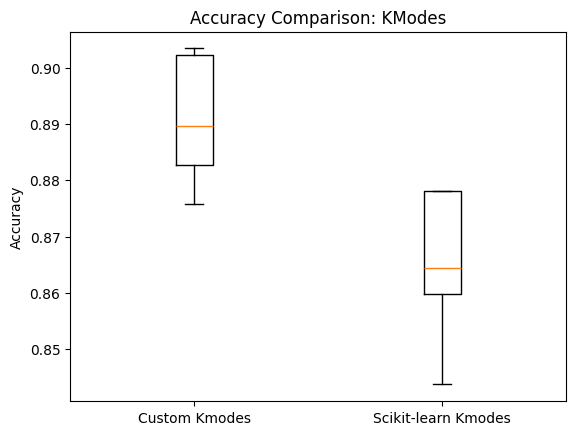

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from kmodes.kmodes import KModes
from sklearn.metrics import accuracy_score, adjusted_rand_score
from tqdm import tqdm

def initialize_centroids(data, k):
    centroids = data.sample(k).values
    return centroids

# def calculate_distance(x, centroids):     # using the squared euclidean distance
#     distances = np.sum((x - centroids) ** 2, axis=1)
#     return distances

def calculate_distance(x, centroids):     # using dissimmilarities
    distances = np.zeros(len(centroids))
    for i, centroid in enumerate(centroids):
        distances[i] = np.sum(x != centroid)
        
    return distances

def assign_clusters(data, centroids):
    distances = np.apply_along_axis(calculate_distance, 1, data.values, centroids)
    clusters = np.argmin(distances, axis=1)
    return clusters

def update_centroids(data, clusters, k):
    centroids = np.zeros((k, data.shape[1]))

    for i in range(k):
        cluster_instances = data[clusters == i]

        if not cluster_instances.empty:
            for j in range(data.shape[1]): #nbr of cols
                mode_values = cluster_instances.iloc[:, j].mode()
                if not mode_values.empty:
                    centroids[i, j] = mode_values.values[0] # to take 1st mode

    return centroids

def kmodes_plus(data, k, num_iterations=50):
    for _ in tqdm(range(num_iterations), desc="Running Iterations", leave=False):
        centroids = initialize_centroids(data, k)

        for _ in range(50):
            clusters = assign_clusters(data, centroids)
            centroids = update_centroids(data, clusters, k)
    return clusters, centroids

def align_clusters(clusters, true_labels):
    unique_clusters = np.unique(clusters)
    aligned_clusters = np.zeros_like(clusters)
    for cluster in unique_clusters:
        true_label = pd.Series(true_labels[clusters == cluster]).mode()[0]
        aligned_clusters[clusters == cluster] = true_label
    return aligned_clusters


dataset = pd.read_csv('vote.csv')
true_labels = dataset.iloc[:, -1].values

num_iterations = 50
custaccuracy_results = []
custrand_index_results = []
sklearn_accuracy_results = []
sklearn_rand_index_results = []

for _ in tqdm(range(num_iterations), desc="Running Iterations"):
    # Using my custom kmodes_plus
    clusters, _ = kmodes_plus(dataset, k=2, num_iterations=50)
    custaligned_clusters = align_clusters(clusters, true_labels)
    custaccuracy = accuracy_score(true_labels, custaligned_clusters)
    custrand_index = adjusted_rand_score(true_labels, custaligned_clusters)
    custaccuracy_results.append(custaccuracy)
    custrand_index_results.append(custrand_index)

    # Using sklearn kmodes
    sklearnkmodes = KModes(n_clusters=2, init='Huang', n_init=1, verbose=0)
    sklearn_clusters = sklearnkmodes.fit_predict(dataset.iloc[:, :-1])
    sklearn_alignedclusters = align_clusters(sklearn_clusters, true_labels) # Aligning clusters
    sklearnaccuracy = accuracy_score(true_labels, sklearn_alignedclusters)
    sklearnrand_index = adjusted_rand_score(true_labels, sklearn_alignedclusters)
    sklearn_accuracy_results.append(sklearnaccuracy)
    sklearn_rand_index_results.append(sklearnrand_index)

custavg_accuracy = np.mean(custaccuracy_results)
custavg_rand_index = np.mean(custrand_index_results)
print("Custom KModes Average Accuracy :", custavg_accuracy)
print("Custom KModes Average Rand Index :", custavg_rand_index)

sklavg_custom_accuracy = np.mean(sklearn_accuracy_results)
sklavg_custom_rand_index = np.mean(sklearn_rand_index_results)
print("SKLearn Kmodes Average Accuracy:", sklavg_custom_accuracy)
print("SKLearn Kmodes Average Rand Index:", sklavg_custom_rand_index)

plt.boxplot([custaccuracy_results, sklearn_accuracy_results], labels=['Custom Kmodes', 'Scikit-learn Kmodes'])
plt.title('Accuracy Comparison: KModes')
plt.ylabel('Accuracy')
plt.show()


In [4]:
print("std:", np.std(custaccuracy_results))
print("std:", np.std(custrand_index_results))

std: 0.009888905960281639
std: 0.031017994529438223
